# Importing dataset
The database used is DB1 (set B) from FVC2000 competition (https://doi.org/10.1109/34.990140).

In [ ]:
!unzip -qq /content/DB1_B.zip -d /content/DB1_B

# Extracting feature vectors
Developed modified method requires biometric features to be represented by ordered tuple of real numbers. For the purpose of demonstration a relatively simple implementation of fingerprint feature extraction with Gabor kernel is used.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import time

In [ ]:
def calculate_orientation_field(img, window_size = 16, blur_size=3, threshold=0.1):
  height, width = img.shape
  f_height = height // window_size
  f_width = width // window_size
  height = f_height * window_size
  width = f_width * window_size
  img_blur = cv2.GaussianBlur(img[:height, :width], (blur_size, blur_size), 0)
  gx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0, ksize=3)
  gy = cv2.Sobel(img_blur, cv2.CV_64F, 0, 1, ksize=3)
  new_shape = (f_height, window_size, f_width, window_size)
  vx = (gx*gy).reshape(new_shape).sum(axis=(1,3))*2
  vy = (gy**2-gx**2).reshape(new_shape).sum(axis=(1,3))
  vx = cv2.GaussianBlur(vx, (3,3), 0)
  vy = cv2.GaussianBlur(vy, (3,3), 0)
  magnitude = np.sqrt(gx**2 + gy**2).reshape(new_shape).sum(axis=(1,3))
  orientation = np.arctan2(vx, vy)/2
  orientation[magnitude < threshold] = 0
  return orientation, magnitude

In [ ]:
def calculate_poincare_index(field):
  poincare = np.ndarray((field.shape[0]-2, field.shape[1]-2))
  for i in range(field.shape[0]-2):
    for j in range(field.shape[1]-2):
      P = 0
      t = field[i,j]
      for k in range(8):
        if k%4<2:
          i += 1 if k<4 else -1
        else:
          j += 1 if k<4 else -1
        d = t
        t = field[i,j]
        d = t - d
        if d <= -np.pi/2:
          d += np.pi
        elif d >= np.pi/2:
          d -= np.pi
        P += d
      poincare[i,j] = P
  return poincare/(2*np.pi)

In [ ]:
def get_pivot(poincare, weights):
  singular = np.nonzero(np.abs(poincare)>0.1)
  singular_val = poincare[singular]
  if len(singular_val) == 0:
    return None
  w = weights[singular[0]+1,singular[1]+1]
  center = (np.average(singular[0], weights = w), np.average(singular[1], weights=w))
  return center

In [ ]:
def calculate_fingercode(img, center, ROI_r = 100, circle_n = 5, direction_n = 16, direction_gabor = 8):
  X,Y = np.ogrid[:img.shape[0], :img.shape[1]]
  dist = (X-center[0])**2+(Y-center[1])**2
  angle = np.arctan2(Y-center[1],X-center[0])+np.pi
  fingercode = np.ndarray((direction_gabor,circle_n,direction_n))
  for i in range(circle_n):
    for j in range(direction_n):
      mask = np.logical_and(np.logical_and((ROI_r*(i+2)/(circle_n+2))**2 < dist, dist <= (ROI_r*(i+3)/(circle_n+2))**2), np.logical_and(np.pi*2*j/direction_n < angle, angle <= np.pi*2*(j+1)/direction_n))
      for k in range(direction_gabor):
        gabor_kernel = cv2.getGaborKernel((33,33), 5, k*np.pi/direction_gabor, 10, 1, np.pi*2)
        filtered = cv2.filter2D(img, kernel=gabor_kernel, ddepth=-1)
        pixels = filtered[mask]
        fingercode[k,i,j] = np.mean(np.abs(pixels - np.mean(pixels))) if pixels.shape[0] else 0
  return fingercode

In [ ]:
ROI_r = 100
circle_n = 4
direction_n = 8
window_size = 12
def process_fingerprint(img):
  orientation, magnitude = calculate_orientation_field(img, window_size=window_size)
  poincare = calculate_poincare_index(orientation)
  pivot = get_pivot(poincare, weights=(magnitude/np.max(magnitude))**2)
  if pivot is None:
    return None
  pivot = (pivot[0]*window_size+window_size*1.5,pivot[1]*window_size+window_size*1.5)
  img_normalized = -(img-np.mean(img))/np.std(img)
  fingercode = calculate_fingercode(img_normalized, pivot, ROI_r, circle_n, direction_n)
  return fingercode

# Biohashing and its modifictions

In [ ]:
def gram_schmidt(m):
  m[0] /= np.linalg.norm(m[0])
  for i in range(1, m.shape[0]):
    m[i] -= np.dot(np.dot(m[i], m[:i].T), m[:i])
    m[i] /= np.linalg.norm(m[i])

For comparison regular biohashing is implemented.

In [ ]:
def biohashing_reuse_b(biometric_vector, basis):
  return np.dot(basis, biometric_vector) > 0

def biohashing(biometric_vector, seed, dimension):
  rng = np.random.default_rng(seed)
  B = rng.random((dimension, biometric_vector.shape[0]))*2-1
  gram_schmidt(B)
  return biohashing_reuse_b(biometric_vector, B)

The following method implements MLP-hash with optional normalization (without normalization it corresponds to base MLP-hash, although normalization may be thought of as a part of activation function).

In [ ]:
def biohashing_nonlinear(biometric_vector, seed, layer_sizes, layer_functions, normalizer = None):
  rng = np.random.default_rng(seed)
  if not isinstance(layer_functions, list):
    layer_functions = [layer_functions for _ in range(len(layer_sizes))]
  for l, f in zip(layer_sizes, layer_functions):
    B = rng.random((l, biometric_vector.shape[0]))*2-1
    gram_schmidt(B)
    if normalizer:
      biometric_vector = normalizer(biometric_vector)
    biometric_vector = f(np.dot(B, biometric_vector))
  return biometric_vector > 0

The following method implements MLP-hash with projection matrix replaced with block matrix where blocks that do not lie on main diagonal are zero.

In [ ]:
def biohashing_block_nonlinear(biometric_vector, seed, layer_sizes, layer_functions, block_numbers):
  rng = np.random.default_rng(seed)
  if not isinstance(layer_functions, list):
    layer_functions = [layer_functions for _ in range(len(layer_sizes))]
  for l, f, b in zip(layer_sizes, layer_functions, block_numbers):
    block_shape = (l//b, biometric_vector.shape[0]//b)
    B = rng.random((b, block_shape[0], block_shape[1]))*2-1
    biometric_vector = rng.permutation(biometric_vector)
    new_biometric_vector = np.ndarray(l)
    for i in range(b):
      gram_schmidt(B[i])
      new_biometric_vector[i*block_shape[0]:(i+1)*block_shape[0]] = np.dot(B[i], biometric_vector[i*block_shape[1]:(i+1)*block_shape[1]])
    biometric_vector = f(new_biometric_vector)
  biometric_vector = rng.permutation(biometric_vector)
  return biometric_vector > 0

The following method implements MLP-hash with multiple projection spaces.

In [ ]:
def biohashing_nonlinear_mp(biometric_vector, seed, layer_sizes, layer_functions, normalizer = None, projection_n = None):
  rng = np.random.default_rng(seed)
  if not isinstance(layer_functions, list):
    layer_functions = [layer_functions for _ in range(len(layer_sizes))]
  if projection_n is None:
    projection_n = 1
  if not isinstance(projection_n, list):
    projection_n = [projection_n for _ in range(len(layer_sizes))]
  for l, f, p in zip(layer_sizes, layer_functions, projection_n):
    B = np.ndarray((l*p, biometric_vector.shape[0]))
    for i in range(p):
      B[l*i:l*(i+1), :] = rng.random((l, biometric_vector.shape[0]))*2-1
      gram_schmidt(B[l*i:l*(i+1), :])
    if normalizer:
      biometric_vector = normalizer(biometric_vector)
    biometric_vector = f(np.dot(B, biometric_vector))

  return biometric_vector > 0

The following method implements MLP-hash with multiple projection spaces and with projection matrix replaced with block matrix where blocks that do not lie on main diagonal are zero.

In [ ]:
def biohashing_block_nonlinear_mp(biometric_vector, seed, layer_sizes, layer_functions, block_numbers, projection_n = None):
  rng = np.random.default_rng(seed)
  if not isinstance(layer_functions, list):
    layer_functions = [layer_functions for _ in range(len(layer_sizes))]
  if projection_n is None:
    projection_n = 1
  if not isinstance(projection_n, list):
    projection_n = [projection_n for _ in range(len(layer_sizes))]
  for l, f, b, p in zip(layer_sizes, layer_functions, block_numbers, projection_n):
    block_shape = (l//b, biometric_vector.shape[0]//b)
    B = rng.random((b*p, block_shape[0], block_shape[1]))*2-1
    biometric_vector = rng.permutation(biometric_vector)
    new_biometric_vector = np.ndarray(l*p)
    for i in range(b):
      for j in range(p):
        gram_schmidt(B[i*p+j])
        new_biometric_vector[(i*p+j)*block_shape[0]:(i*p+j+1)*block_shape[0]] = np.dot(B[i*p+j], biometric_vector[i*block_shape[1]:(i+1)*block_shape[1]])
    biometric_vector = f(new_biometric_vector)
  biometric_vector = rng.permutation(biometric_vector)
  return biometric_vector > 0

# Data unpacking

In [ ]:
import os
fnames = dict()
for fname in os.listdir('/content/DB1_B'):
  h = fname.split('_')[0]
  if h in fnames:
    fnames[h].append(fname)
  else:
    fnames[h] = [fname]
images = {k:[cv2.imread('/content/DB1_B/'+fname, cv2.IMREAD_UNCHANGED)for fname in v] for k,v in fnames.items()}

# Biometric data visualisations

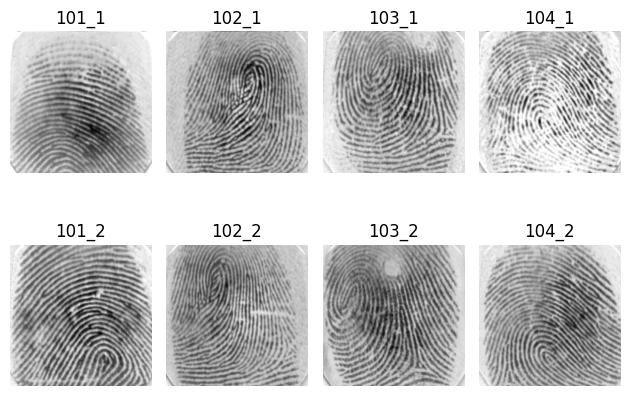

In [ ]:
fig, axes = plt.subplots(2,4)
for i in range(4):
  for j in range(2):
    axes[j][i].imshow(images[f'10{(1+i)}'][j], cmap='gray')
    axes[j][i].set_axis_off()
    axes[j][i].set_title(f'10{i+1}_{j+1}')
plt.tight_layout()

In [ ]:
def plot_orientation_field(img, field, magnitude = 1, window_size=16):
  fig, ax = plt.subplots()
  ax.imshow(img, cmap='gray')
  X, Y = np.meshgrid(np.arange(0,field.shape[0])*window_size+window_size/2, np.arange(0,field.shape[1])*window_size+window_size/2)
  U, V = np.cos(field)*magnitude, np.sin(field)*magnitude
  ax.quiver(X, Y, U, V, pivot='mid', color='red')

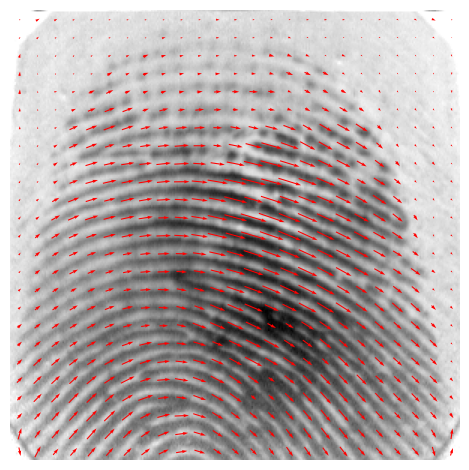

In [ ]:
window_size = 12

orientation, magnitude = calculate_orientation_field(images['101'][0], window_size = window_size)

plot_orientation_field(images['101'][0], orientation, magnitude, window_size = window_size)
plt.gca().set_axis_off()
plt.tight_layout()

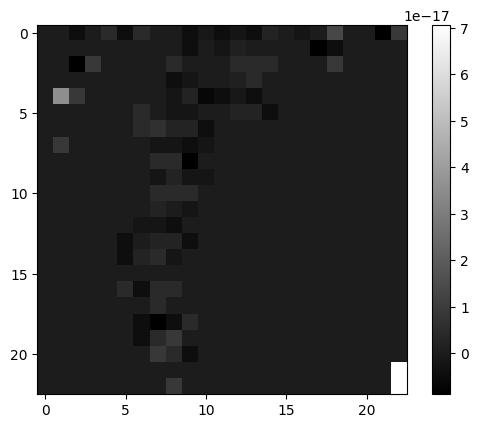

In [ ]:
poincare = calculate_poincare_index(orientation)
plt.imshow(poincare, cmap='gray')
plt.colorbar()

In [ ]:
pivot = get_pivot(poincare, weights=(magnitude/np.max(magnitude))**2)
if pivot is None:
  print('pivot extraction failed, default value used in following visuals')
  pivot = (12,12)
pivot = (pivot[0]*window_size+window_size*1.5,pivot[1]*window_size+window_size*1.5)

pivot extraction failed, default value used in following visuals


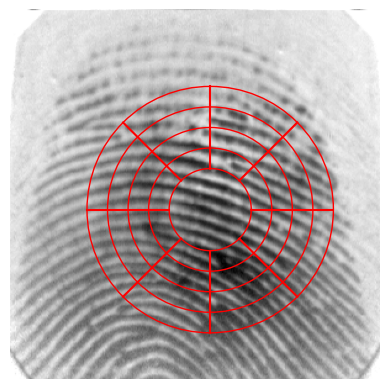

In [ ]:
fig, ax = plt.subplots()
ax.imshow(images['101'][0], cmap='gray')
ax.set_axis_off()
for i in range(circle_n+1):
  circle = plt.Circle((pivot[1], pivot[0]), ROI_r*(i+2)/(circle_n+2), fill = False, color = 'red')
  ax.add_patch(circle)
for i in range(direction_n):
  ax.plot((pivot[1]+ROI_r*2*np.cos(2*np.pi*i/direction_n)/(circle_n+2), pivot[1]+ROI_r*np.cos(2*np.pi*i/direction_n)), (pivot[0]+ROI_r*2*np.sin(2*np.pi*i/direction_n)/(circle_n+2), pivot[0]+ROI_r*np.sin(2*np.pi*i/direction_n)), color = 'red')

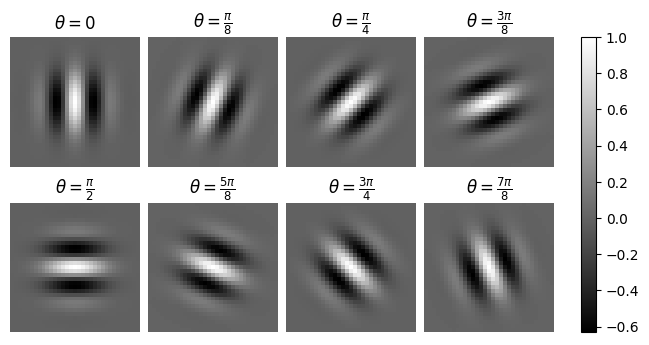

In [ ]:
fig, axes = plt.subplots(2,4,layout='compressed')
for k in range(8):
  gabor_kernel = cv2.getGaborKernel((33,33), 5, k*np.pi/8, 10, 1, np.pi*2)
  im = axes[k//4,k%4].imshow(gabor_kernel, cmap='gray')
  axes[k//4,k%4].set_axis_off()
  k_gcd = np.gcd(8,k)
  axes[k//4,k%4].set_title(f'$\\theta = 0$' if k==0 else f'$\\theta = \\frac{{{"" if k==k_gcd else k//k_gcd}\\pi}}{{{8 // k_gcd}}}$')
fig.colorbar(im, ax=axes)

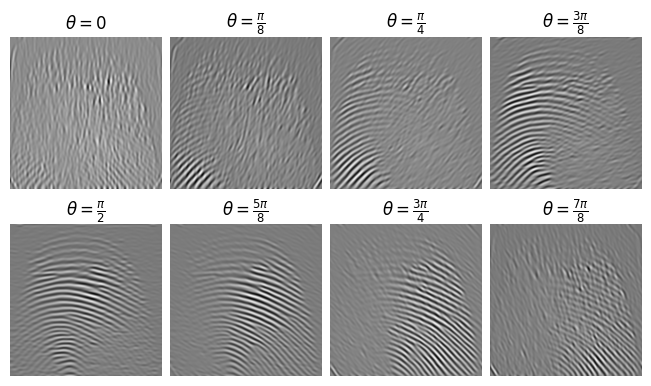

In [ ]:
img_for_filtering = images['101'][0]
img_for_filtering = -(img_for_filtering-np.mean(img_for_filtering))/np.std(img_for_filtering)
fig, axes = plt.subplots(2,4,layout='compressed')
img_combine = np.zeros(img_for_filtering.shape)
filtered_imgs = []
for i in range(8):
  gabor_kernel = cv2.getGaborKernel((33,33), 4, i*np.pi/8, 8, 1, np.pi*2)
  filtered = cv2.filter2D(img_for_filtering, kernel=gabor_kernel, ddepth=-1)
  axes[i//4,i%4].imshow(filtered, cmap='gray')
  img_combine+=filtered.astype('float64')
  filtered_imgs.append(filtered)
  axes[i//4,i%4].set_axis_off()
  k_gcd = np.gcd(8,i)
  axes[i//4,i%4].set_title(f'$\\theta = 0$' if i==0 else f'$\\theta = \\frac{{{"" if i==k_gcd else i//k_gcd}\\pi}}{{{8 // k_gcd}}}$')

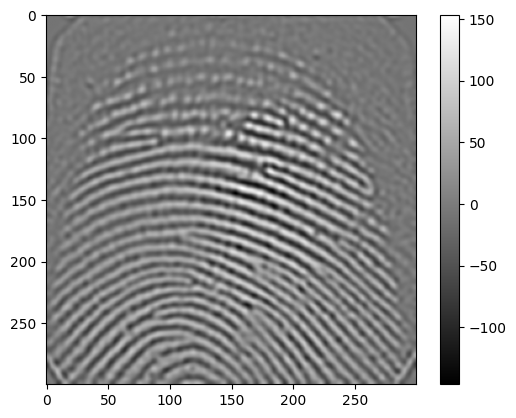

In [ ]:
plt.imshow(img_combine, cmap='gray')
plt.colorbar()

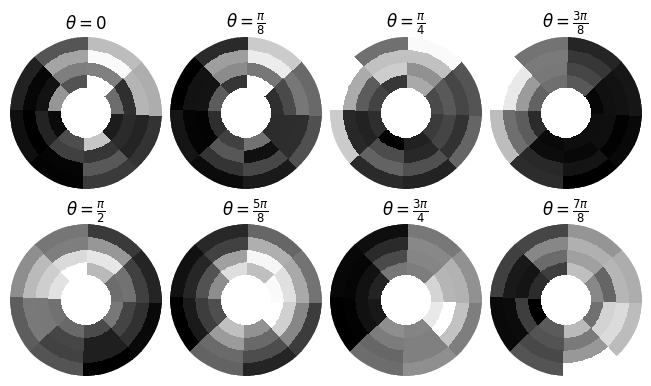

In [ ]:
fingercode = calculate_fingercode(img_for_filtering, pivot, ROI_r, circle_n, direction_n)
subdivs=10
inner_circles = 2
fingercode_for_visuals = np.ndarray(fingercode.shape+np.array([0,inner_circles,0]))
fingercode_for_visuals[:,inner_circles:,:] = fingercode
fingercode_for_visuals[:,:inner_circles,:] = np.nan
fig, ax = plt.subplots(2,4, layout='compressed', subplot_kw={'projection': 'polar'})
r,a = np.meshgrid(np.arange(circle_n+inner_circles)/(circle_n+inner_circles),np.arange(direction_n*subdivs)*2*np.pi/(direction_n*subdivs)+np.pi/2)
for k in range(8):
  ax[k//4,k%4].pcolormesh(a,r,np.repeat(np.transpose(fingercode_for_visuals[k]), subdivs, axis=0),shading='auto',cmap='gray')
  ax[k//4,k%4].set_axis_off()
  k_gcd = np.gcd(8,k)
  ax[k//4,k%4].set_title(f'$\\theta = 0$' if k==0 else f'$\\theta = \\frac{{{"" if k==k_gcd else k//k_gcd}\\pi}}{{{8 // k_gcd}}}$')

# Experiments

In [ ]:
fingercodes = {k:[] for k in fnames}
for k,v in images.items():
  for img in v:
    fc = process_fingerprint(img)
    if fc is not None:
      fingercodes[k].append(fc.reshape(-1))

Images for which no singular point is detected are discarded.

In [ ]:
fingercodes_n = sum([len(v) for _,v in fingercodes.items()])
fingercodes_n

79

The following method takes as inputs lists of distances (or similarity metric values, in this case `reverse` must be set to `True`) between different genuine user samples (`genuine_list`) and between genuine and imposter samples (`imposter_list`) and calculates FAR and FRR for different threshold values (in this case for all values proveded in lists).

In [ ]:
def get_far_frr_eer(genuine_list, imposter_list, reverse = False):
  all_list = [(x, True) for x in genuine_list]+[(x,False) for x in imposter_list]
  all_list.sort(key = lambda x:x[0], reverse = reverse)
  fr = len(genuine_list)
  fa = 0
  frr = []
  far = []
  frr_pre = 0
  far_pre = 0
  pre_err = True
  eer = 0
  for x in all_list:
    if x[1]:
      fr -=1
    else:
      fa += 1
    frr_curr = fr/len(genuine_list)
    far_curr = fa/len(imposter_list)
    if pre_err:
      if frr_curr < far_curr:
        pre_err = False
        eer = (frr_pre+far_pre+frr_curr+far_curr)/4
      else:
        frr_pre = frr_curr
        far_pre = far_curr
    frr.append(frr_curr)
    far.append(far_curr)
  return far,frr,eer

The following function takes representations (as dictionary where samples of the same person are grouped into one value as list) and distance metric and calculates pairwise distances between samples of the same person and between samples of different people.

In [ ]:
def get_distance_genuine_imposter(representations, distance_func):
  distances_genuine = []
  distances_imposter = []
  for v in representations.values():
    for i in range(len(v)-1):
      b1 = v[i]
      for b2 in v[i+1:]:
        distances_genuine.append(distance_func(b1,b2))
  keys = [k for k in representations.keys()]
  for i in range(len(keys)-1):
    k1 = keys[i]
    for k2 in keys[i+1:]:
      for b1 in representations[k1]:
        for b2 in representations[k2]:
          distances_imposter.append(distance_func(b1,b2))
  return distances_genuine, distances_imposter

In [ ]:
def hamming_distance(a,b):
  return (a!=b).sum()

def cosine_similarity(a,b):
  return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

For comparison FRR-FAR graph and EER of authentication by unprotected biometric templates (where cosine similarity is used to compare samples) is shown.

EER = 0.16856176231176234


(np.float64(-0.05),
 np.float64(1.05),
 np.float64(-0.04981684981684982),
 np.float64(1.0501831501831502))

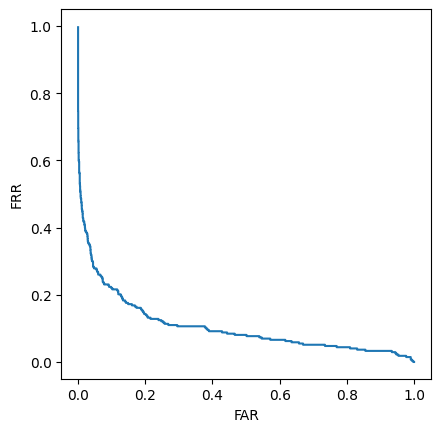

In [ ]:
cos_g, cos_i = get_distance_genuine_imposter(fingercodes, cosine_similarity)
far,frr,eer = get_far_frr_eer(cos_g, cos_i, reverse=True)
plt.plot(far, frr)
plt.xlabel('FAR')
plt.ylabel('FRR')
print('EER =', eer)
plt.axis('square')

Histograms of cosine similarity values for genuine and imposter users.

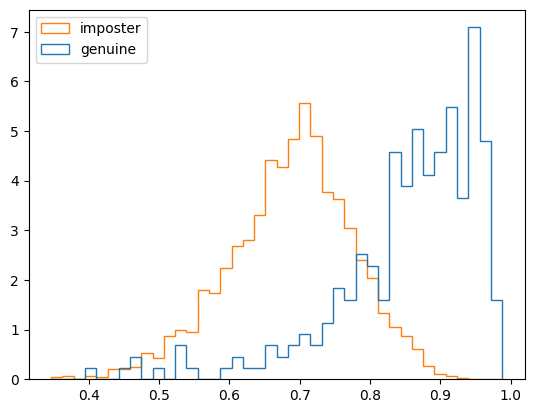

In [ ]:
plt.hist([cos_g, cos_i], bins = 40, histtype = 'step', density = True, label=['genuine', 'imposter'])
plt.legend()

For all other methods the distance metric used is Hamming distance.

Biohashing effectiveness is evaluated in two scenarios: base scenario, in which imposter does not know users secret key, and stolen key scenario, where genuine and imposter users use the same key.

EER = 0.22345594220594223
EER = 0.001093813593813594


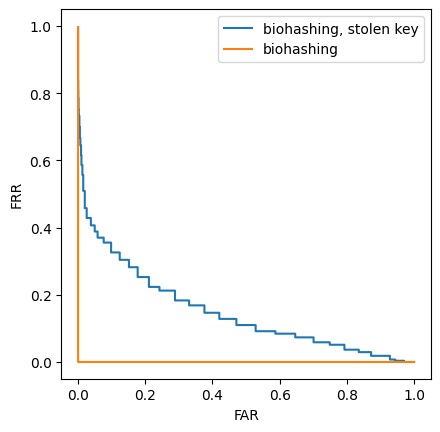

In [ ]:
biohashes_same = {k:[biohashing(fc**2, 222, 128) for fc in v] for k,v in fingercodes.items()}
b_s_g, b_s_i = get_distance_genuine_imposter(biohashes_same, hamming_distance)
far,frr,eer = get_far_frr_eer(b_s_g, b_s_i)
plt.plot(far, frr, label = 'biohashing, stolen key')
plt.xlabel('FAR')
plt.ylabel('FRR')
print('EER =', eer)

token_rng = np.random.default_rng(42)
tokens = {k:token_rng.integers(0,1000000) for k in fingercodes.keys()}
biohashes_different = {k:[biohashing(fc, tokens[k], 128) for fc in v] for k,v in fingercodes.items()}
b_d_g, b_d_i = get_distance_genuine_imposter(biohashes_different, hamming_distance)
far,frr,eer = get_far_frr_eer(b_d_g, b_d_i)
plt.plot(far, frr, label = 'biohashing')
plt.xlabel('FAR')
plt.ylabel('FRR')
print('EER =', eer)

plt.axis('square')

plt.legend()

In base scenario histograms of Hamming distances between different samples of genuine user and between genuine und imposter users are almost separated.

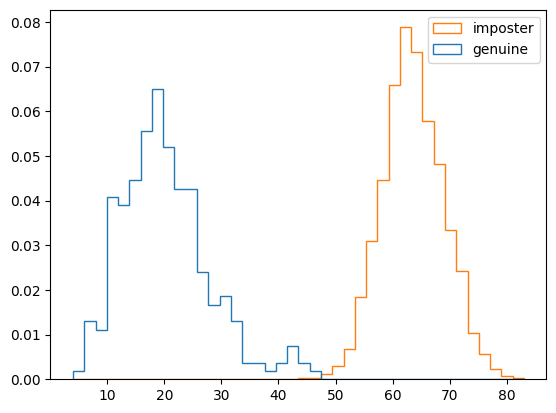

In [ ]:
plt.hist([b_d_g, b_d_i], bins = 40, histtype = 'step', density = True, label=['genuine', 'imposter'])
plt.legend()

In [ ]:
def norm_minmax(x):
  x_min = np.min(x)
  return (x - x_min)/(np.max(x)-x_min)

def norm_minmax_symmetric(x):
  x_min = np.min(x)
  return 2*(x - x_min)/(np.max(x)-x_min) - 1

def norm_l2(x):
  return x / np.linalg.norm(x)

def norm_statistical(x):
  return (x - np.mean(x)) / np.std(x)

def ReLU(x):
  return np.where(x>0, x, 0)

def leaky_ReLU(x):
  return np.where(x>0, x, x*0.5)

def custom_f(x):
  return 0.7*x + 0.3*np.abs(x)*np.sin(x)

far_frr_eers_stolen = dict()
far_frr_eers = dict()

avg_time = 0

for f, f_n in [(ReLU, 'ReLU'), (leaky_ReLU, 'leaky ReLU'), (np.tanh, 'tanh'), (custom_f, 'custom')]:
  far_frr_eers[f_n] = dict()
  far_frr_eers_stolen[f_n] = dict()
  for norm, norm_n in [(None, 'None'), (norm_minmax_symmetric, 'min-max'), (norm_l2, 'l2'), (norm_statistical, 'statistical')]:
    start_time = time.time()
    biohashes_same = {k:[biohashing_nonlinear(fc**2, 222, [128, 128, 128], f, norm) for fc in v] for k,v in fingercodes.items()}
    end_time = time.time()
    avg_time+=end_time-start_time
    b_s_g, b_s_i = get_distance_genuine_imposter(biohashes_same, hamming_distance)
    far,frr,eer = get_far_frr_eer(b_s_g, b_s_i)
    far_frr_eers_stolen[f_n][norm_n] = (far,frr,eer)

    token_rng = np.random.default_rng(42)
    tokens = {k:token_rng.integers(0,1000000) for k in fingercodes.keys()}
    start_time = time.time()
    biohashes_different = {k:[biohashing_nonlinear(fc, tokens[k], [128,128,128], f, norm) for fc in v] for k,v in fingercodes.items()}
    end_time = time.time()
    avg_time+=end_time-start_time
    b_d_g, b_d_i = get_distance_genuine_imposter(biohashes_different, hamming_distance)
    far,frr,eer = get_far_frr_eer(b_d_g, b_d_i)
    far_frr_eers[f_n][norm_n] = (far,frr,eer)

avg_time /= fingercodes_n*4*4*2
avg_time

0.006697086216528205

Comparison of EER values for different normalizations and different nonlinear transformations when imposter does not know users secret key:

In [ ]:
eer_df = pd.DataFrame({k:{k2:v2[2] for k2,v2 in v.items()} for k,v in far_frr_eers.items()})
eer_df

,ReLU,leaky ReLU,tanh,custom
None,0.000089,0.001094,0.007313,0.010925
min-max,0.000089,0.001094,0.000089,0.021940
l2,0.000089,0.001094,0.000089,0.000089
statistical,0.146533,0.100758,0.111416,0.103658


Comparison of EER values for different normalizations and different nonlinear transformations in stolen key scenario:

In [ ]:
eer_stolen_df = pd.DataFrame({k:{k2:v2[2] for k2,v2 in v.items()} for k,v in far_frr_eers_stolen.items()})
eer_stolen_df

,ReLU,leaky ReLU,tanh,custom
None,0.260111,0.208829,0.275921,0.223456
min-max,0.305886,0.295050,0.283323,0.310211
l2,0.260111,0.208829,0.209834,0.204212
statistical,0.223456,0.213624,0.219844,0.196276


Comparison of FRR-FAR for different normalizations when leaky ReLU is used as nonlinear transformations:

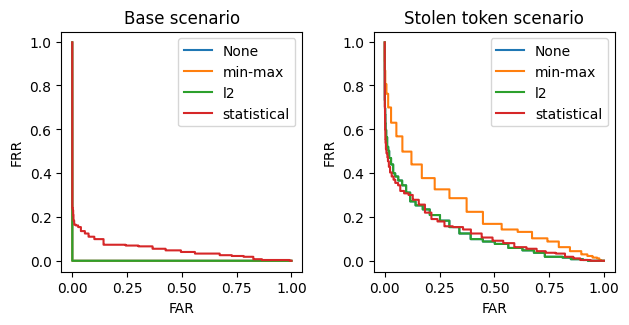

In [ ]:
fig, axes = plt.subplots(1,2)

for k,v in far_frr_eers['leaky ReLU'].items():
  axes[0].plot(v[0], v[1], label = k)

axes[0].set_xlabel('FAR')
axes[0].set_ylabel('FRR')
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend()
axes[0].set_title('Base scenario')

for k,v in far_frr_eers_stolen['leaky ReLU'].items():
  axes[1].plot(v[0], v[1], label = k)

axes[1].set_xlabel('FAR')
axes[1].set_ylabel('FRR')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
axes[1].set_title('Stolen token scenario')

plt.tight_layout()

Comparison of FRR-FAR for different nonlinear transformations when l2 normalization is used:

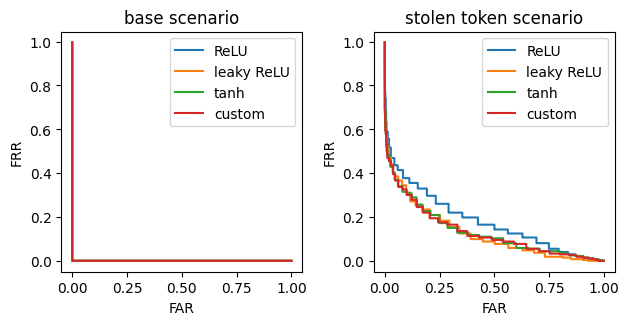

In [ ]:
fig, axes = plt.subplots(1,2)

for k,v in far_frr_eers.items():
  axes[0].plot(v['l2'][0], v['l2'][1], label = k)

axes[0].set_xlabel('FAR')
axes[0].set_ylabel('FRR')
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend()
axes[0].set_title('base scenario')

for k,v in far_frr_eers_stolen.items():
  axes[1].plot(v['l2'][0], v['l2'][1], label = k)

axes[1].set_xlabel('FAR')
axes[1].set_ylabel('FRR')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
axes[1].set_title('stolen token scenario')

plt.tight_layout()

In [ ]:
far_frr_eers_b_stolen = dict()
far_frr_eers_b = dict()

avg_time_b = 0

for f, f_n in [(ReLU, 'ReLU'), (leaky_ReLU, 'leaky ReLU'), (np.tanh, 'tanh'), (custom_f, 'custom')]:
  far_frr_eers_b[f_n] = dict()
  far_frr_eers_b_stolen[f_n] = dict()
  for norm, norm_n in [(None, 'None'), (norm_minmax_symmetric, 'min-max'), (norm_l2, 'l2'), (norm_statistical, 'statistical')]:
    start_time = time.time()
    biohashes_same = {k:[biohashing_block_nonlinear(fc**2, 222, [128, 128, 128], lambda x: f(norm(x) if norm else x), [8,8,8]) for fc in v] for k,v in fingercodes.items()}
    end_time = time.time()
    avg_time_b += end_time-start_time
    b_s_g, b_s_i = get_distance_genuine_imposter(biohashes_same, hamming_distance)
    far,frr,eer = get_far_frr_eer(b_s_g, b_s_i)
    far_frr_eers_b_stolen[f_n][norm_n] = (far,frr,eer)

    token_rng = np.random.default_rng(42)
    tokens = {k:token_rng.integers(0,1000000) for k in fingercodes.keys()}
    start_time = time.time()
    biohashes_different = {k:[biohashing_block_nonlinear(fc, tokens[k], [128,128,128], lambda x: f(norm(x)if norm else x), [8,8,8]) for fc in v] for k,v in fingercodes.items()}
    end_time = time.time()
    avg_time_b += end_time-start_time
    b_d_g, b_d_i = get_distance_genuine_imposter(biohashes_different, hamming_distance)
    far,frr,eer = get_far_frr_eer(b_d_g, b_d_i)
    far_frr_eers_b[f_n][norm_n] = (far,frr,eer)

avg_time_b /= fingercodes_n*4*4*2

Average time of creation a protected template with block matrix:

In [ ]:
avg_time_b

0.00437948088857192

Comparison of average time of creation of a protected templated with regular matrix and with block matrix where non-diagonal blocks are zero matrices:

In [ ]:
avg_time/avg_time_b

1.5291963561261297

Comparison of EER valuse for different normalizations and nonlinear transformations for method with block matrix if secret key is not known to imposter:

In [ ]:
eer_b_df = pd.DataFrame({k:{k2:v2[2] for k2,v2 in v.items()} for k,v in far_frr_eers_b.items()})
eer_b_df

,ReLU,leaky ReLU,tanh,custom
None,0.000089,0.005240,0.031059,0.007313
min-max,0.054983,0.012821,0.018328,0.018328
l2,0.000089,0.005240,0.007313,0.009921
statistical,0.000089,0.003701,0.014716,0.010925


Comparison of EER valuse for different normalizations and nonlinear transformations for method with block matrix in stolen key scenario:

In [ ]:
eer_b_stolen_df = pd.DataFrame({k:{k2:v2[2] for k2,v2 in v.items()} for k,v in far_frr_eers_b_stolen.items()})
eer_b_stolen_df

,ReLU,leaky ReLU,tanh,custom
None,0.276455,0.208829,0.204034,0.211259
min-max,0.378307,0.296767,0.271126,0.241695
l2,0.276455,0.208829,0.190413,0.190413
statistical,0.254960,0.212441,0.183188,0.186800


Comparison of effectiveness of MLP-hash with block matrix and with regular matrix:

In [ ]:
eer_b_stolen_df - eer_stolen_df

,ReLU,leaky ReLU,tanh,custom
None,0.016344,0.000000,-0.071886,-0.012197
min-max,0.072421,0.001717,-0.012197,-0.068516
l2,0.016344,0.000000,-0.019422,-0.013800
statistical,0.031504,-0.001183,-0.036655,-0.009475


In [ ]:
eer_b_df - eer_df

,ReLU,leaky ReLU,tanh,custom
None,0.000000,0.004146,0.023746,-0.003612
min-max,0.054894,0.011727,0.018239,-0.003612
l2,0.000000,0.004146,0.007224,0.009832
statistical,-0.146444,-0.097057,-0.096701,-0.092732


Comparison of FRR-FAR for MLP-hash with block matrix with different normalizations when tanh is used as nonlinear transformations:

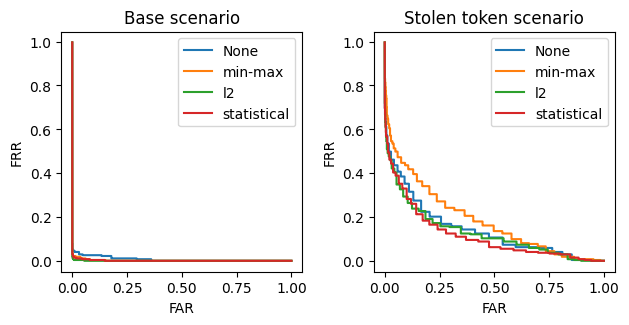

In [ ]:
fig, axes = plt.subplots(1,2)

for k,v in far_frr_eers_b['tanh'].items():
  axes[0].plot(v[0], v[1], label = k)

axes[0].set_xlabel('FAR')
axes[0].set_ylabel('FRR')
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend()
axes[0].set_title('Base scenario')

for k,v in far_frr_eers_b_stolen['tanh'].items():
  axes[1].plot(v[0], v[1], label = k)

axes[1].set_xlabel('FAR')
axes[1].set_ylabel('FRR')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
axes[1].set_title('Stolen token scenario')

plt.tight_layout()


Comparison of FRR-FAR for MLP-hash with block matrix with different nonlinear transformations when l2 normalization is used:

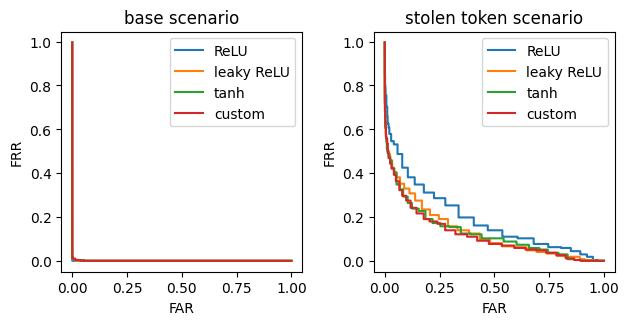

In [ ]:
fig, axes = plt.subplots(1,2)

for k,v in far_frr_eers_b.items():
  axes[0].plot(v['l2'][0], v['l2'][1], label = k)

axes[0].set_xlabel('FAR')
axes[0].set_ylabel('FRR')
axes[0].set_aspect('equal', adjustable='box')
axes[0].legend()
axes[0].set_title('base scenario')

for k,v in far_frr_eers_b_stolen.items():
  axes[1].plot(v['l2'][0], v['l2'][1], label = k)

axes[1].set_xlabel('FAR')
axes[1].set_ylabel('FRR')
axes[1].set_aspect('equal', adjustable='box')
axes[1].legend()
axes[1].set_title('stolen token scenario')

plt.tight_layout()


Comparison of FRR-FAR of biometric authentication based on unprotected features (similarity metric is cosine similarity), biohashing in base and stolen key scenarios and modified MLP-hash with block matrix in base and stolen key scenarios (distance metric for biohashing- and MLP-hashing-based authentication is Hamming distance):

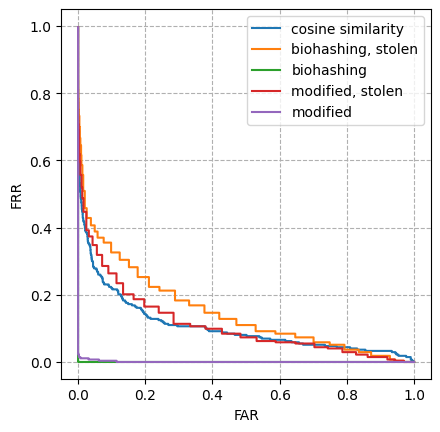

In [ ]:
far,frr,eer = get_far_frr_eer(cos_g, cos_i, reverse=True)
plt.plot(far, frr, label='cosine similarity')


biohashes_same = {k:[biohashing(fc**2, 222, 128) for fc in v] for k,v in fingercodes.items()}
b_s_g, b_s_i = get_distance_genuine_imposter(biohashes_same, hamming_distance)
far,frr,eer = get_far_frr_eer(b_s_g, b_s_i)
plt.plot(far, frr, label = 'biohashing, stolen')

token_rng = np.random.default_rng(42)
tokens = {k:token_rng.integers(0,1000000) for k in fingercodes.keys()}
biohashes_different = {k:[biohashing(fc, tokens[k], 128) for fc in v] for k,v in fingercodes.items()}
b_d_g, b_d_i = get_distance_genuine_imposter(biohashes_different, hamming_distance)
far,frr,eer = get_far_frr_eer(b_d_g, b_d_i)
plt.plot(far, frr, label = 'biohashing')

f = custom_f
norm = norm_statistical

biohashes_same = {k:[biohashing_block_nonlinear(fc**2, 222, [128, 128, 128], lambda x: f(norm(x) if norm else x), [8,8,8]) for fc in v] for k,v in fingercodes.items()}
avg_time_b += end_time-start_time
b_s_g, b_s_i = get_distance_genuine_imposter(biohashes_same, hamming_distance)
far,frr,eer = get_far_frr_eer(b_s_g, b_s_i)
plt.plot(far, frr, label = 'modified, stolen')

token_rng = np.random.default_rng(42)
tokens = {k:token_rng.integers(0,1000000) for k in fingercodes.keys()}
biohashes_different = {k:[biohashing_block_nonlinear(fc, tokens[k], [128,128,128], lambda x: f(norm(x)if norm else x), [8,8,8]) for fc in v] for k,v in fingercodes.items()}
b_d_g, b_d_i = get_distance_genuine_imposter(biohashes_different, hamming_distance)
far,frr,eer = get_far_frr_eer(b_d_g, b_d_i)
plt.plot(far, frr, label = 'modified')



plt.xlabel('FAR')
plt.ylabel('FRR')
plt.grid(linestyle='--')
plt.axis('square')
plt.legend()
plt.savefig('Fig_1.tif', dpi=300, bbox_inches='tight', pad_inches=0)

Comparison of distances between samples of genuine users, between samples of different people (imposter), between samples of genuine users with different keys for each sample (random genuine) and between samples of different people with each sample having different key (random imposter):

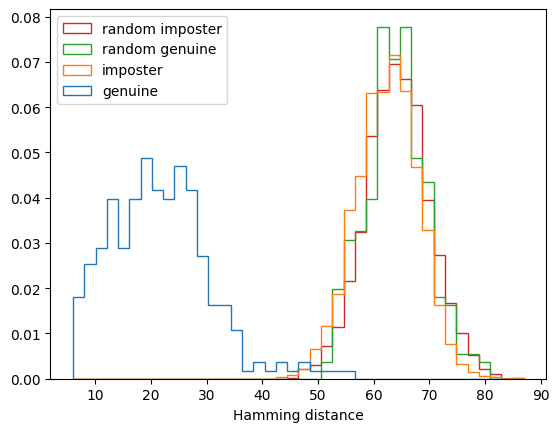

In [ ]:
token_rng = np.random.default_rng(42)
biohashes_random = {k:[biohashing_block_nonlinear(fc, token_rng.integers(0,1000000), [128,128,128], lambda x: f(norm(x)if norm else x), [8,8,8]) for fc in v] for k,v in fingercodes.items()}
b_r_g, b_r_i = get_distance_genuine_imposter(biohashes_random, hamming_distance)

plt.hist([b_d_g, b_d_i, b_r_g, b_r_i], bins = 40, histtype = 'step', density = True, label=['genuine', 'imposter', 'random genuine', 'random imposter'])
plt.legend()
plt.xlabel('Hamming distance')
plt.savefig('Fig_2.tif', dpi=300, bbox_inches='tight', pad_inches=0)

Measures of execution time:

In [ ]:
avg_times = dict()

for proj_num in [1,2,4,8,16]:

  avg_time = 0
  f =custom_f
  norm = norm_statistical
  start_time = time.time()
  biohashes_same = {k:[biohashing_nonlinear_mp(fc**2, 222, [128, 128*proj_num, 128*proj_num], f, norm, [proj_num, 1, 1]) for fc in v] for k,v in fingercodes.items()}
  end_time = time.time()
  avg_time+=end_time-start_time
  avg_time /= fingercodes_n
  avg_times[proj_num] = avg_time

In [ ]:
avg_times

{1: 0.00974985014034223,
 2: 0.017471262171298643,
 4: 0.10765863973883134,
 8: 1.5120955177500277,
 16: 7.540924358971512}

In [ ]:
avg_times_b = dict()

for proj_num in [1,2,4,8,16]:
  avg_times_b_p = dict()
  for block_num in [2,4,8,16]:
    avg_time = 0
    f =custom_f
    norm = norm_statistical
    start_time = time.time()
    biohashes_same = {k:[biohashing_block_nonlinear_mp(fc**2, 222, [128, 128*proj_num, 128*proj_num], lambda x: f(norm(x) if norm else x), [block_num,block_num,block_num], [proj_num, 1, 1]) for fc in v] for k,v in fingercodes.items()}
    end_time = time.time()
    avg_time+=end_time-start_time
    avg_time /= fingercodes_n
    avg_times_b_p[block_num] = avg_time
  avg_times_b[proj_num] = avg_times_b_p

In [ ]:
avg_times_b

{1: {2: 0.004071075705033314,
  4: 0.0036955302274679835,
  8: 0.0036698896673661246,
  16: 0.003275116787681097},
 2: {2: 0.00944712493993059,
  4: 0.007271875309038766,
  8: 0.006957600388345839,
  16: 0.006494425520112243},
 4: {2: 0.037940707387803474,
  4: 0.019800026205521595,
  8: 0.014189146742036071,
  16: 0.013235535802720468},
 8: {2: 0.1985786051689824,
  4: 0.05667470980294143,
  8: 0.04394949538798272,
  16: 0.0276121610327612},
 16: {2: 1.9521939814845217,
  4: 0.3952792867829528,
  8: 0.11883972868134704,
  16: 0.0661295516581475}}

In [ ]:
times_s = pd.Series(avg_times)
times_s

,0
1,0.009750
2,0.017471
4,0.107659
8,1.512096
16,7.540924


In [ ]:
times_b_df = pd.DataFrame(avg_times_b)
times_b_df

,1,2,4,8,16
2,0.004071,0.009447,0.037941,0.198579,1.952194
4,0.003696,0.007272,0.019800,0.056675,0.395279
8,0.003670,0.006958,0.014189,0.043949,0.118840
16,0.003275,0.006494,0.013236,0.027612,0.066130


In [ ]:
times_s / times_b_df

,1,2,4,8,16
2,2.394908,1.849373,2.837550,7.614594,3.862795
4,2.638282,2.402580,5.437298,26.680252,19.077459
8,2.656715,2.511105,7.587393,34.405299,63.454574
16,2.976947,2.690194,8.134060,54.761940,114.032595
